In [10]:
import os
_ROOTDIR = '/your/root/dir'
import numpy as np
from matplotlib import pyplot as plt
os.chdir(_ROOTDIR)
from utils import *

**Stage 1**: Setup

In [4]:
# Instantiate modulation functions and groundtruth kernels for {1-regularised Laplacian, 2-regularised Laplacian, 2-step random walk, heat, cosine} kernels.
modulation = ModulationFunctions()  
groundtruth_kernels = GroundtruthKernels()

In [5]:
# Get a list of adjacency matrices. Here, we just load common examples saved in a .npy file, but you can import your own.
As = np.load('adj_matrices.npy',allow_pickle=True)

In [6]:
# Choose the hyperparameters.
sigma = 0.5  # Scalar regulariser <1 to ensure that the groundtruth kernels converge
p_halt = 0.5  # Walker termination probability
nb_random_walks = [2,4,8,16]  # Numbers of random walks /node to sample.
trials = 10  # Number of repeats per number of walks per graph.

**Stage 2:** Compute kernel approximations using graph random features, as described in 'General graph random features' by Reid et al.

In [7]:
# Approximate the graph kernels using the GRFs method. 

# Holders for approximation error means and standard deviations.
graphs_all_means = []
graphs_all_stds = []

for graph_id,A in enumerate(As):

    print('Approximating kernels for graph ' + str(graph_id+1) + ' of 8...')   
    all_errors = []
    all_stds = []

    for kernel_index in range(5):
        U = get_U_matrix(A, sigma)  # Normalise the adjacency matrix
        groundtruth = groundtruth_kernels.get_groundtruth_kernel(kernel_index+1, U)  # Compute groundtruth kernel
        nb_vertices = len(A)  # Count the number of vertices.
        adj_lists, weight_lists = adj_matrix_to_lists(U)  # Get the adjacency and weights lists

        # Instantiate lists to hold errors
        errors_log = []
        stds_log = []

        for walks in nb_random_walks:
            errors = []

            for trial in range(trials):
                all_walks_list = get_all_walks_list(adj_lists, p_halt, walks)  # Compute the walks
                approx_mat = get_approx_gram_mat(U, adj_lists, p_halt, all_walks_list, modulation.functions[kernel_index+1])  # Approximate the Gram matrix using GRFs
                errors.append(frob_norm_error(groundtruth, approx_mat))  # Record the approximation error
            errors_log.append(np.mean(errors))
            stds_log.append(np.std(errors) / np.sqrt(trials))

        all_errors.append(errors_log)
        all_stds.append(stds_log)

    all_errors = np.asarray(all_errors)
    all_stds = np.asarray(all_stds)

    graphs_all_means.append(all_errors)
    graphs_all_stds.append(all_stds)

print('Done.')

Approximating kernels for graph 1 of 8...


Approximating kernels for graph 2 of 8...
Approximating kernels for graph 3 of 8...
Approximating kernels for graph 4 of 8...
Approximating kernels for graph 5 of 8...
Approximating kernels for graph 6 of 8...
Approximating kernels for graph 7 of 8...
Approximating kernels for graph 8 of 8...
Done.


**Stage 3:** Plot the results.

(Note for pedants: actual values differ slightly from Fig. 2 of the paper because of different choices of hyperparameters, but same relationship and conclusions.)

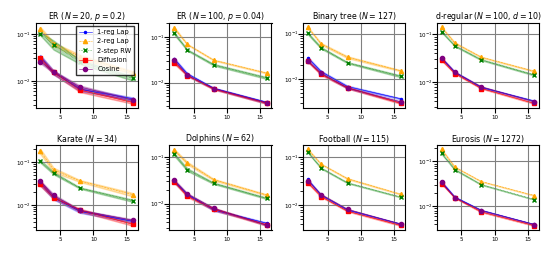

In [8]:
# Adjust matplotlib params
plt.rcParams.update({'font.size': 4})
plt.rcParams['lines.linewidth'] = 0.4
plt.rcParams['xtick.major.pad'] = 1.5
plt.rcParams['ytick.major.pad'] = 0
plt.rcParams['ytick.minor.pad'] = 0
plt.rcParams['ytick.minor.width']=0.6
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'

# Helper function to make plot for a single graph
def do_single_plot(means, stds,nb_rnd_walks_list):
    "Plotting func for data from GRFs experiment"
    
    linestyles = ['solid','dashed','dotted', 'solid','solid']

    labels = ['1-reg Lap','2-reg Lap','2-step RW','Diffusion','Cosine']
    markers=['.','^','x','s','o']
    colors = ['blue','orange','green','red','purple']

    nb_rnd_walks_list = np.asarray(nb_rnd_walks_list)
    means = np.asarray(means)
    stds = np.asarray(stds)

    for i in range(5):
        plt.plot(nb_rnd_walks_list, means[i], label = labels[i], linestyle = linestyles[i],marker = markers[i],markersize=3, color=colors[i])
        plt.fill_between(nb_rnd_walks_list, means[i] - stds[i], means[i]+stds[i], alpha = 0.3, color=colors[i])
       
    
    plt.xlabel("No. random walks", labelpad = 0.25, size=5)
    plt.ylabel("Frob. norm error", labelpad = 0.25, size=5)
    plt.grid(color='grey')
    

fig, axes = plt.subplots(2,4, figsize=(5.41,2.5))
titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'd-regular ($N=100$, $d=10$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]

# Do the plots.
for graph_id in range(8):
    plt.subplot(2,4,graph_id+1)
    
    do_single_plot(graphs_all_means[graph_id], graphs_all_stds[graph_id], nb_random_walks)
    if graph_id == 0:
        plt.legend()
    plt.title(titles[graph_id],pad=2,fontsize=5.7)
    
    plt.yscale('log')

for ax in axes.flatten():
    ax.set_facecolor('white')
    ax.tick_params(colors='black', which='both')  # Set tick colors to black
    ax.spines['bottom'].set_color('black')  # Set bottom spine to black
    ax.spines['left'].set_color('black')    # Set left spine to black
    ax.spines['top'].set_color('black')  # Set bottom spine to black
    ax.spines['right'].set_color('black')    # Set left spine to black

plt.tight_layout()
plt.show()
